In [1]:
import SimpleITK as sitk
import numpy as np

In [4]:
img = sitk.GetArrayFromImage(sitk.ReadImage("data/longciu_img.nii.gz"))
one = sitk.GetArrayFromImage(sitk.ReadImage("data/longciu_1_tgt.nii.gz"))
two = sitk.GetArrayFromImage(sitk.ReadImage("data/longciu_2_tgt.nii.gz"))
three = sitk.GetArrayFromImage(sitk.ReadImage("data/longciu_3_tgt.nii.gz"))
staple = sitk.GetArrayFromImage(sitk.ReadImage("data/longciu_STAPLE_tgt.nii.gz"))
pred = sitk.GetArrayFromImage(sitk.ReadImage("data/longciu_medpseg_output.nii.gz"))

# Cohen Kappa

In [5]:

import itertools
from sklearn.metrics import cohen_kappa_score
import seaborn as sns
import matplotlib.pyplot as plt
import multiprocessing as mp


def compute_ck(raters):
    data = np.zeros((len(raters), len(raters)))
    # Calculate cohen_kappa_score for every combination of raters
    # Combinations are only calculated j -> k, but not k -> j, which are equal
    # So not all places in the matrix are filled.
    for j, k in list(itertools.combinations(range(len(raters)), r=2)):
        data[j, k] = cohen_kappa_score(raters[j], raters[k])
    
    return data


def cohen_kappa(data, raters, title, yticklabels=None, xticklabels=None):
    if yticklabels is None:
        yticklabels = [f"Rater {k + 1}" for k in range(len(raters))]
    if xticklabels is None:
        xticklabels = [f"Rater {k + 1}" for k in range(len(raters))]

    sns.heatmap(
        data, 
        mask=np.tri(len(raters)),
        annot=True, linewidths=5,
        vmin=0, vmax=1,
        xticklabels=xticklabels,
        yticklabels=yticklabels,
    )
    plt.title(title)
    plt.show()



# Interrater including MEDPSeg

In [6]:
def remove_healthy(x):
    nx = np.copy(x).astype(np.float32)
    nx = nx - 1
    nx[nx < 0] = 0

    return nx.astype(x.dtype)

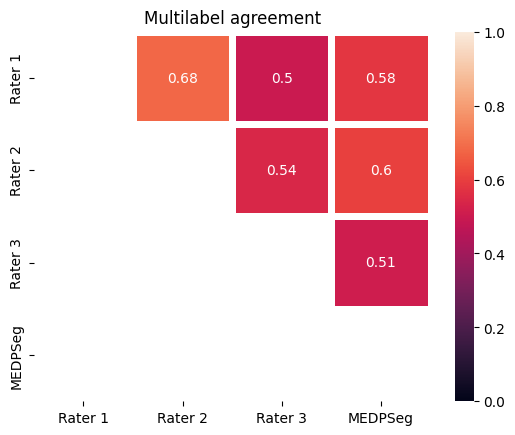

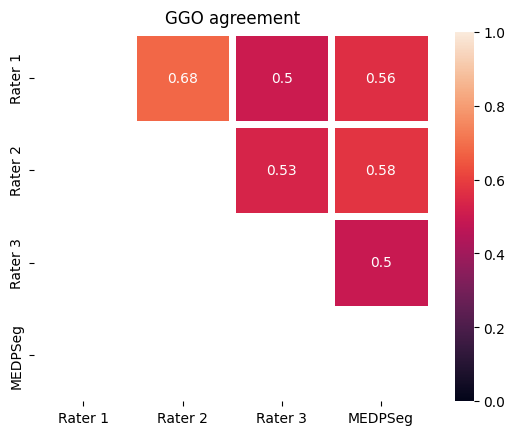

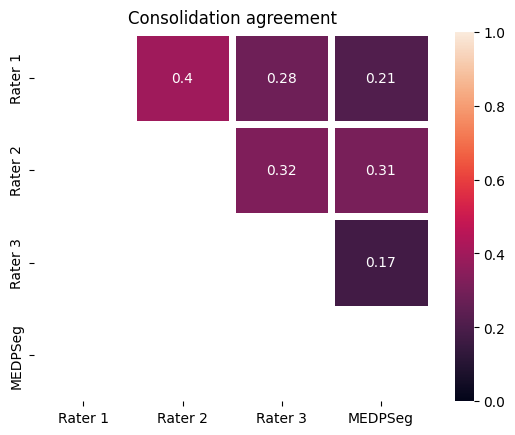

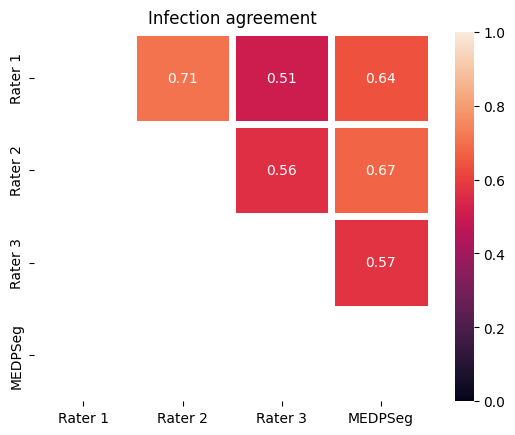

In [7]:
nh_pred = remove_healthy(pred)

raters = [[one.flatten(), two.flatten(), three.flatten(), nh_pred.flatten()],
          [(one == 1).flatten(), (two == 1).flatten(), (three == 1).flatten(), (nh_pred == 1).flatten()],
          [(one == 2).flatten(), (two == 2).flatten(), (three == 2).flatten(), (nh_pred == 2).flatten()],
          [(one > 0).flatten(), (two > 0).flatten(), (three > 0).flatten(), (nh_pred > 0).flatten()]]

titles = ["Multilabel agreement", "GGO agreement", "Consolidation agreement", "Infection agreement"]

with mp.Pool(4) as pool:
    for data, rater, title in zip(pool.imap(compute_ck, raters), raters, titles):
        labels = ["Rater 1", "Rater 2", "Rater 3", "MEDPSeg"]
        cohen_kappa(data, rater, title, yticklabels=labels, xticklabels=labels)